In [2]:
%matplotlib inline
import sqlite3 as sql
import jpype as jp
import json
import numpy as np
import matplotlib.pyplot as plt
import palettable

In [19]:
class PyTimber:
    JAR = '/afs/cern.ch/work/c/chernals/private/accsoft-cals-extr-client-nodep.jar'
    
    def __init__(self, clientName='LHC_MD_ABP_ANALYSIS', appName='BEAM_PHYSICS'):
        if jp.isJVMStarted():
            print("Warning! The JVM is already running.")
        else:
            jp.startJVM(jp.getDefaultJVMPath(), "-Djava.class.path={0}".format(PyTimber.JAR))

        self._cals = jp.JPackage("cern").accsoft.cals
        self._metaDS = self._cals.extr.client.service.ServiceBuilder.getInstance(clientName, appName, self._cals.extr.domain.core.datasource.DataLocationPreferences.MDB_AND_LDB_PRO).createMetaService()
        self._timeseriesDS = self._cals.extr.client.service.ServiceBuilder.getInstance(clientName, appName, self._cals.extr.domain.core.datasource.DataLocationPreferences.MDB_AND_LDB_PRO).createTimeseriesService()
        
    def getData(self, v, time1, time2):
        results = {}
        t1 = self._cals.extr.domain.util.TimestampFactory.parseUTCTimestamp(time1)
        t2 = self._cals.extr.domain.util.TimestampFactory.parseUTCTimestamp(time2)
        variables = self._metaDS.getVariablesWithNameInListofStrings(jp.java.util.Arrays.asList(v))
        iterator = variables.iterator()
        while iterator.hasNext():
            v = iterator.next()
            values = self._timeseriesDS.getDataInTimeWindow(v,t1,t2)
            print("Retrieved {0} values for {1}".format(values.size(), v.getVariableName()))
            results[v.getVariableName()] = np.empty([values.size(), 2])
            for i in range(0, values.size()):
                results[v.getVariableName()][i,0] = values.getTimeSeriesData(i).getStamp().getTime()
                results[v.getVariableName()][i,1] = values.getTimeSeriesData(i).getDoubleValue()
        return results
    
    def getDataFiltered(self, v, time1, time2, cycle):
        results = {}
        t1 = self._cals.extr.domain.util.TimestampFactory.parseUTCTimestamp(time1)
        t2 = self._cals.extr.domain.util.TimestampFactory.parseUTCTimestamp(time2)

        fundamentals = self._metaDS.getFundamentalsInTimeWindowWithNameLikePattern(t1, t2, cycle)
        print(fundamentals.getVariable(0).getVariableName())
        variables = self._metaDS.getVariablesWithNameInListofStrings(jp.java.util.Arrays.asList(v))
        iterator = variables.iterator()
        while iterator.hasNext():
            v = iterator.next()
            values = self._timeseriesDS.getDataInTimeWindowFilteredByFundamentals(v,t1,t2,fundamentals)
            datatype = values.getVariableDataType().toString()
            print("Retrieved {0} values for {1}".format(values.size(), v.getVariableName()))
            results[v.getVariableName()] = {}
            results[v.getVariableName()]['date'] = np.empty(values.size())
            if datatype == 'NUMERIC':
                results[v.getVariableName()]['value']= np.empty([values.size(), 1])
            elif datatype == 'VECTORNUMERIC':
                results[v.getVariableName()]['value']= [0 for x in range(values.size())]
            elif datatype == 'MATRIXNUMERIC':
                results[v.getVariableName()]['value']= [0 for x in range(values.size())]
            else:
                results[v.getVariableName()]['value']= np.empty([values.size(), 1])
            for i in range(0, values.size()):
                results[v.getVariableName()]['date'][i] = values.getTimeSeriesData(i).getStamp().getTime()
                if datatype == 'VECTORNUMERIC':
                    results[v.getVariableName()]['value'][i] = np.array(values.getTimeSeriesData(i).getDoubleValues())
                elif datatype == 'NUMERIC':
                    results[v.getVariableName()]['value'][i] = values.getTimeSeriesData(i).getDoubleValue()
                elif datatype == 'FUNDAMENTAL':
                    results[v.getVariableName()]['value'][i] = 1
                elif datatype == 'MATRIXNUMERIC':
                    results[v.getVariableName()]['value'][i] = np.array(values.getTimeSeriesData(i).getMatrixDoubleValues())
                else:
                    print('Unsupported datatype')
                    print(datatype)
        return results
    
    def getCyclePresence(self, time1, time2, cycle):
        t1 = self._cals.extr.domain.util.TimestampFactory.parseUTCTimestamp(time1)
        t2 = self._cals.extr.domain.util.TimestampFactory.parseUTCTimestamp(time2)
        
        fundamentals = self._metaDS.getFundamentalsInTimeWindowWithNameLikePattern(t1, t2, cycle)
        
        r = []
        if fundamentals is not None:
            r = fundamentals.getVariableNames().toArray()
            print(r)
        else:
            print('Cycle not found.')
        return r

In [20]:
date1='2015-11-04T03:00:00.000';
date2='2015-11-04T04:00:00.000';
lhc_cycles = t.getCyclePresence(date1, date2, 'SPS:LHC%')
lhc_cycle_data = t.getDataFiltered(lhc_cycles, date1, date2, 'SPS:LHC%')
cyclePS='CPS:MTE_1600:SFTPRO2'
cycleSPS='SPS:SFT_PRO_MTE_L4830_2014_V1:SFTPRO2'
devicesPS=['PR.DCBEFEJE_1:INTENSITY']
dataPS = t.getDataFiltered(devicesPS, date1, date2, cyclePS)

('SPS:LHC_PILOT_SLOW_FB300_FT500_Q20_2015_V1:LHCPILOT', 'SPS:LHC_INDIV_SLOW_Q20_2015_V1:LHCINDIV', 'SPS:LHC_25NS_SLOW_2INJ_Q20_2015_V1:LHC25NS')
SPS:LHC_25NS_SLOW_2INJ_Q20_2015_V1:LHC25NS
Retrieved 51 values for SPS:LHC_25NS_SLOW_2INJ_Q20_2015_V1:LHC25NS
Retrieved 7 values for SPS:LHC_INDIV_SLOW_Q20_2015_V1:LHCINDIV
Retrieved 10 values for SPS:LHC_PILOT_SLOW_FB300_FT500_Q20_2015_V1:LHCPILOT
CPS:MTE_1600:SFTPRO2
Retrieved 270 values for PR.DCBEFEJE_1:INTENSITY


In [7]:
# Dataset CT
date1='2015-09-19T00:00:00.000'
date2='2015-09-20T00:00:00.000'
cyclePS='CPS:SFTPRO_CT_:SFTPRO1'
cycleSPS='SPS:SFT_PRO_L4830_2014_V1:SFTPRO1'
devicesPS=['F16.BCT.126:TOTAL_INTENSITY', \
           'F16.BCT.203:TOTAL_INTENSITY', \
           'F16.BCT.212:TOTAL_INTENSITY', \
           'F16.BCT.372:TOTAL_INTENSITY', \
           'PR.DCBEFEJE_1:INTENSITY']
devicesSPS=['SPS.BCTDC.31832:TOTAL_INT', \
            'TT10.BCTFI.102834:INT_INJ1', \
            'TT10.BCTFI.102834:INT_INJ2']
dataPS = t.getDataFiltered(devicesPS, date1, date2, cyclePS)
dataSPS = t.getDataFiltered(devicesSPS, date1, date2, cycleSPS)
trCT = detailedTransmission(dataPS, dataSPS)
1-np.median(trCT['total'])

CPS:SFTPRO_CT_:SFTPRO1
Retrieved 8717 values for F16.BCT.126:TOTAL_INTENSITY
Retrieved 8717 values for F16.BCT.203:TOTAL_INTENSITY
Retrieved 8717 values for F16.BCT.212:TOTAL_INTENSITY
Retrieved 8717 values for F16.BCT.372:TOTAL_INTENSITY
Retrieved 8717 values for PR.DCBEFEJE_1:INTENSITY
SPS:SFT_PRO_L4830_2014_V1:SFTPRO1
Retrieved 4360 values for SPS.BCTDC.31832:TOTAL_INT
Retrieved 4360 values for TT10.BCTFI.102834:INT_INJ1
Retrieved 4360 values for TT10.BCTFI.102834:INT_INJ2


0.11914693414797728

In [8]:
# Dataset MTE
date1='2015-09-29T20:00:00.000';
date2='2015-09-30T01:00:00.000';
cyclePS='CPS:MTE_1600:SFTPRO2'
cycleSPS='SPS:SFT_PRO_MTE_L4830_2014_V1:SFTPRO2'
devicesPS=['F16.BCT.126:TOTAL_INTENSITY', \
           'F16.BCT.203:TOTAL_INTENSITY', \
           'F16.BCT.212:TOTAL_INTENSITY', \
           'F16.BCT.372:TOTAL_INTENSITY', \
           'PR.DCBEFEJE_1:INTENSITY']
devicesSPS=['SPS.BCTDC.31832:TOTAL_INT', \
            'TT10.BCTFI.102834:INT_INJ1', \
            'TT10.BCTFI.102834:INT_INJ2']
dataPS = t.getDataFiltered(devicesPS, date1, date2, cyclePS)
dataSPS = t.getDataFiltered(devicesSPS, date1, date2, cycleSPS)
trMTE = detailedTransmission(dataPS, dataSPS)
1-np.median(trMTE['total'])


CPS:MTE_1600:SFTPRO2
Retrieved 1618 values for F16.BCT.126:TOTAL_INTENSITY
Retrieved 1618 values for F16.BCT.203:TOTAL_INTENSITY
Retrieved 1618 values for F16.BCT.212:TOTAL_INTENSITY
Retrieved 1618 values for F16.BCT.372:TOTAL_INTENSITY
Retrieved 1618 values for PR.DCBEFEJE_1:INTENSITY
SPS:SFT_PRO_MTE_L4830_2014_V1:SFTPRO2
Retrieved 1000 values for SPS.BCTDC.31832:TOTAL_INT
Retrieved 1000 values for TT10.BCTFI.102834:INT_INJ1
Retrieved 1000 values for TT10.BCTFI.102834:INT_INJ2


0.12576327330524817

In [9]:
# Dataset MTE 04/11/2015 with final PSB beam at 1600
date1='2015-11-04T08:00:00.000';
date2='2015-11-04T10:00:00.000';
cyclePS='CPS:MTE_1600:SFTPRO2'
cycleSPS='SPS:SFT_PRO_MTE_L4830_2014_V1:SFTPRO2'
devicesPS=['F16.BCT.126:TOTAL_INTENSITY', \
           'F16.BCT.203:TOTAL_INTENSITY', \
           'F16.BCT.212:TOTAL_INTENSITY', \
           'F16.BCT.372:TOTAL_INTENSITY', \
           'PR.DCBEFEJE_1:INTENSITY']
devicesSPS=['SPS.BCTDC.31832:TOTAL_INT', \
            'TT10.BCTFI.102834:INT_INJ1', \
            'TT10.BCTFI.102834:INT_INJ2']
dataPS = t.getDataFiltered(devicesPS, date1, date2, cyclePS)
dataSPS = t.getDataFiltered(devicesSPS, date1, date2, cycleSPS)
trMTE2 = detailedTransmission(dataPS, dataSPS)
1-np.median(trMTE2['total'])

CPS:MTE_1600:SFTPRO2
Retrieved 472 values for F16.BCT.126:TOTAL_INTENSITY
Retrieved 472 values for F16.BCT.203:TOTAL_INTENSITY
Retrieved 472 values for F16.BCT.212:TOTAL_INTENSITY
Retrieved 472 values for F16.BCT.372:TOTAL_INTENSITY
Retrieved 472 values for PR.DCBEFEJE_1:INTENSITY
SPS:SFT_PRO_MTE_L4830_2014_V1:SFTPRO2
Retrieved 244 values for SPS.BCTDC.31832:TOTAL_INT
Retrieved 244 values for TT10.BCTFI.102834:INT_INJ1
Retrieved 244 values for TT10.BCTFI.102834:INT_INJ2


0.093813481391431308

In [10]:
# Dataset MTE XXX
date1='2015-11-11T07:00:00.000';
date2='2015-11-11T07:30:00.000';
cyclePS='CPS:SFTPRO_MTE_OP:SFTPRO2'
cycleSPS='SPS:SFT_PRO_MTE_L4830_2014_V1:SFTPRO2'
devicesPS=['F16.BCT.126:TOTAL_INTENSITY', \
           'F16.BCT.203:TOTAL_INTENSITY', \
           'F16.BCT.212:TOTAL_INTENSITY', \
           'F16.BCT.372:TOTAL_INTENSITY', \
           'PR.DCBEFEJE_1:INTENSITY']
devicesSPS=['SPS.BCTDC.31832:TOTAL_INT', \
            'TT10.BCTFI.102834:INT_INJ1', \
            'TT10.BCTFI.102834:INT_INJ2']
dataPS = t.getDataFiltered(devicesPS, date1, date2, cyclePS)
dataSPS = t.getDataFiltered(devicesSPS, date1, date2, cycleSPS)
trMTE3 = detailedTransmission(dataPS, dataSPS)
print(1-np.median(trMTE3['total']))
print(np.median(trMTE3['tt2']))
print(np.median(trMTE3['spsInj']))
print(np.median(trMTE3['spsFT']))

CPS:SFTPRO_MTE_OP:SFTPRO2
Retrieved 200 values for F16.BCT.126:TOTAL_INTENSITY
Retrieved 200 values for F16.BCT.203:TOTAL_INTENSITY
Retrieved 200 values for F16.BCT.212:TOTAL_INTENSITY
Retrieved 200 values for F16.BCT.372:TOTAL_INTENSITY
Retrieved 200 values for PR.DCBEFEJE_1:INTENSITY
SPS:SFT_PRO_MTE_L4830_2014_V1:SFTPRO2
Retrieved 100 values for SPS.BCTDC.31832:TOTAL_INT
Retrieved 100 values for TT10.BCTFI.102834:INT_INJ1
Retrieved 100 values for TT10.BCTFI.102834:INT_INJ2
0.123536644827
0.0171593910214
0.0702960919221
0.0361374133545


In [28]:
def beamSynchro(ps, sps, max_offset=1000, injections=2):
    indices = []
    for i, x in enumerate(sps['date']):
        tmp = [i]
        for j, y in enumerate(ps['date']):
            if abs(y - x) < max_offset:
                tmp.append(j)
        if len(tmp) == injections+1:
            indices.append(tmp)
    return indices

In [6]:
def detailedTransmission(dataPS, dataSPS):
    t = {}
    ind = beamSynchro(dataPS['PR.DCBEFEJE_1:INTENSITY'],dataSPS['SPS.BCTDC.31832:TOTAL_INT'])
    
    # Total
    t['total'] = []
    for i in ind:
        if 1.0e-10 * dataSPS['SPS.BCTDC.31832:TOTAL_INT']['value'][i[0]][400] > 2600:
            t['total'].append((1.0e-10 * dataSPS['SPS.BCTDC.31832:TOTAL_INT']['value'][i[0]][400])/ \
                     (dataPS['PR.DCBEFEJE_1:INTENSITY']['value'][i[1]][0]+ \
                      dataPS['PR.DCBEFEJE_1:INTENSITY']['value'][i[2]][0]))
    t['total'] = np.array(t['total'])
    
    # To SPS FT
    t['spsFT'] = []
    for i in ind:
        if 1.0e-10 * dataSPS['SPS.BCTDC.31832:TOTAL_INT']['value'][i[0]][400] > 2600:
            t['spsFT'].append((1.0e-10 * dataSPS['SPS.BCTDC.31832:TOTAL_INT']['value'][i[0]][121]-1.0e-10 * dataSPS['SPS.BCTDC.31832:TOTAL_INT']['value'][i[0]][400])/ \
                     (dataPS['PR.DCBEFEJE_1:INTENSITY']['value'][i[1]][0]+ \
                      dataPS['PR.DCBEFEJE_1:INTENSITY']['value'][i[2]][0]))
    t['spsFT'] = np.array(t['spsFT'])
    
    # To SPS 2nd injection
    t['spsInj'] = []
    for i in ind:
        if 1.0e-10 * dataSPS['SPS.BCTDC.31832:TOTAL_INT']['value'][i[0]][121] > 2600:
            t['spsInj'].append(((dataPS['F16.BCT.126:TOTAL_INTENSITY']['value'][i[1]][0]+ \
                      dataPS['F16.BCT.126:TOTAL_INTENSITY']['value'][i[2]][0])-1.0e-10 * dataSPS['SPS.BCTDC.31832:TOTAL_INT']['value'][i[0]][121])/ \
                     (dataPS['PR.DCBEFEJE_1:INTENSITY']['value'][i[1]][0]+ \
                      dataPS['PR.DCBEFEJE_1:INTENSITY']['value'][i[2]][0]))
    t['spsInj'] = np.array(t['spsInj'])
        
    # To TT2
    t['tt2'] = []
    for i, d in enumerate(dataPS['F16.BCT.126:TOTAL_INTENSITY']['value']):
        if d[0] > 1400:
            norm = dataPS['PR.DCBEFEJE_1:INTENSITY']['value'][i][0]
            t['tt2'].append(  (norm-d[0]) / norm)
    t['tt2'] = np.array(t['tt2'])
    
    return t

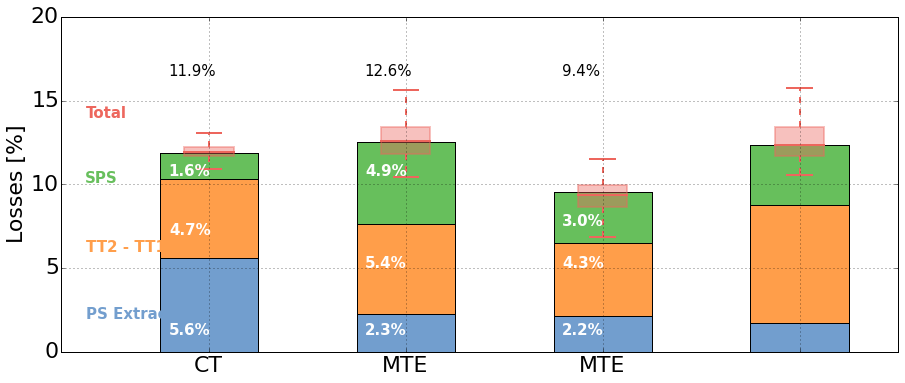

In [24]:
ind = [0.2, 0.6, 1.0, 1.4]
width = 0.2

fig = plt.figure(1, figsize=(15,6), dpi=100)
ax = fig.add_subplot(111)
colors = palettable.colorbrewer.qualitative.Pastel1_4.mpl_colors
colors = palettable.tableau.TableauMedium_10.mpl_colors

bar1 = [100*np.median(trCT['tt2']), 100*np.median(trMTE['tt2']), 100*np.median(trMTE2['tt2']), 100*np.median(trMTE3['tt2'])]
ax.bar(ind, bar1, width=width, color=colors[0])
#ax.boxplot([100*(trCT['tt2']), 100*(trMTE['tt2'])], positions=[0.3, 0.7])

bar2 = [100*np.median(trCT['spsInj']), 100*np.median(trMTE['spsInj']), 100*np.median(trMTE2['spsInj']), 100*np.median(trMTE3['spsInj'])]
ax.bar(ind, bar2, bottom=bar1, width=width, color=colors[1])

bar3 = [100*np.median(trCT['spsFT']), 100*np.median(trMTE['spsFT']), 100*np.median(trMTE2['spsFT']), 100*np.median(trMTE3['spsFT'])]
ax.bar(ind, bar3, bottom=[sum(x) for x in zip(bar1, bar2)], color=colors[2], width=width)

bp1 = ax.boxplot([100*(1-trCT['total']), 100*(1-trMTE['total']), 100*(1-trMTE2['total']), 100*(1-trMTE3['total'])], positions=[0.3, 0.7, 1.1, 1.5], patch_artist=True, widths=0.1, showfliers=False)
stlBoxPlot(bp1, colors[3])

ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_xlabel('', fontsize=22)
ax.set_ylabel('Losses [%]', fontsize=22)
ax.set_xticklabels(['CT', 'MTE', 'MTE'])
ax.set_xlim([0, 1.7])
ax.set_ylim([0, 20])
ax.text(0.22, 1.0, '{:.1f}%'.format(100*np.median(trCT['tt2'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.62, 1.0, '{:.1f}%'.format(100*np.median(trMTE['tt2'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(1.02, 1.0, '{:.1f}%'.format(100*np.median(trMTE2['tt2'])), fontsize=15, fontweight="bold", color=[1,1,1])

ax.text(0.22, 7.0, '{:.1f}%'.format(100*np.median(trCT['spsInj'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.62, 5.0, '{:.1f}%'.format(100*np.median(trMTE['spsInj'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(1.02, 5.0, '{:.1f}%'.format(100*np.median(trMTE2['spsInj'])), fontsize=15, fontweight="bold", color=[1,1,1])

ax.text(0.22, 10.5, '{:.1f}%'.format(100*np.median(trCT['spsFT'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.62, 10.5, '{:.1f}%'.format(100*np.median(trMTE['spsFT'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(1.02, 7.5, '{:.1f}%'.format(100*np.median(trMTE2['spsFT'])), fontsize=15, fontweight="bold", color=[1,1,1])

ax.text(0.22, 16.5, '{:.1f}%'.format(100-100*np.median(trCT['total'])), fontsize=15, color='k')
ax.text(0.62, 16.5, '{:.1f}%'.format(100-100*np.median(trMTE['total'])), fontsize=15, color='k')
ax.text(1.02, 16.5, '{:.1f}%'.format(100-100*np.median(trMTE2['total'])), fontsize=15, color='k')

ax.text(0.05, 2.0, 'PS Extraction', fontsize=15, color=colors[0], fontweight='bold')
ax.text(0.05, 6.0, 'TT2 - TT10', fontsize=15, color=colors[1], fontweight='bold')
ax.text(0.05, 10.1, 'SPS', fontsize=15, color=colors[2], fontweight='bold')
ax.text(0.05, 14.0, 'Total', fontsize=15, color=colors[3], fontweight='bold')

fig.savefig('plot.pdf')

In [ ]:
## VERSION FOR BE NEWSLETTER

ind = [0.2, 0.5, 0.8]
width = 0.2

fig = plt.figure(1, dpi=100)
ax = fig.add_subplot(111)
colors = palettable.colorbrewer.qualitative.Pastel1_4.mpl_colors
colors = palettable.tableau.TableauMedium_10.mpl_colors

bar1 = [100*np.median(trCT['tt2']), 100*np.median(trMTE['tt2']), 100*np.median(trMTE2['tt2'])]
ax.bar(ind, bar1, width=width, color='b')
#ax.boxplot([100*(trCT['tt2']), 100*(trMTE['tt2'])], positions=[0.3, 0.7])
bp1 = ax.boxplot([-100*(1-trCT['total']), -100*(1-trMTE['total']), -100*np.median(trMTE['tt2'])], positions=[0.3, 0.6, 0.9])
bar2 = [100*np.median(trCT['spsInj']), 100*np.median(trMTE['spsInj']), 100*np.median(trMTE2['spsInj'])]
ax.bar(ind, bar2, bottom=bar1, width=width, color=[0, 0.9, 0])
bar3 = [100*np.median(trCT['spsFT']), 100*np.median(trMTE['spsFT']), 100*np.median(trMTE2['spsFT'])]
ax.bar(ind, bar3, bottom=[sum(x) for x in zip(bar1, bar2)], color='r', width=width)

ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_xlabel('', fontsize=22)
ax.set_ylabel('Losses [%]', fontsize=22)
ax.set_xticklabels(['CT', 'MTE', 'MTE'])
ax.set_xlim([0, 1.1])
ax.set_ylim([0, 20])
ax.text(0.22, 1.0, '{:.1f}%'.format(100*np.median(trCT['tt2'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.52, 1.0, '{:.1f}%'.format(100*np.median(trMTE['tt2'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.82, 1.0, '{:.1f}%'.format(100*np.median(trMTE2['tt2'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.22, 7.0, '{:.1f}%'.format(100*np.median(trCT['spsInj'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.52, 5.0, '{:.1f}%'.format(100*np.median(trMTE['spsInj'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.82, 5.0, '{:.1f}%'.format(100*np.median(trMTE2['spsInj'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.22, 10.5, '{:.1f}%'.format(100*np.median(trCT['spsFT'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.52, 10.5, '{:.1f}%'.format(100*np.median(trMTE['spsFT'])), fontsize=15, fontweight="bold", color=[1,1,1])
ax.text(0.82, 8.5, '{:.1f}%'.format(100*np.median(trMTE2['spsFT'])), fontsize=15, fontweight="bold", color=[1,1,1])

ax.text(0.04, 2.0, 'PS Extraction', fontsize=15, color='b', fontweight='bold')
ax.text(0.04, 6.0, 'TT2 - TT10', fontsize=15, color=[0, 0.8, 0], fontweight='bold')
ax.text(0.04, 10.1, 'SPS', fontsize=15, color='r', fontweight='bold')

ax.text(0.25, 15.2, '19/09/2015', fontsize=16)
ax.text(0.55, 15.2, '29/09/2015', fontsize=16)
ax.text(0.85, 15.2, '04/11/2015', fontsize=16)

fig.savefig('plot.pdf')

/user/bdisoft/operational/bin/Python/Anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


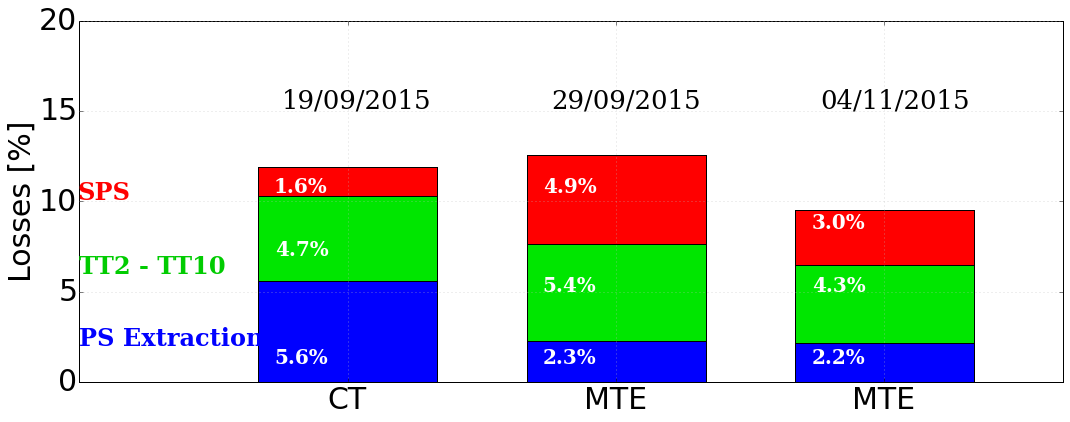

In [31]:
## VERSION FOR PAUL

ind = [0.2, 0.5, 0.8]
width = 0.2

with plt.style.context('word'):
    fig = plt.figure(1, figsize=(15,6), dpi=100)
    ax = fig.add_subplot(111)
    colors = palettable.colorbrewer.qualitative.Pastel1_4.mpl_colors
    colors = palettable.tableau.TableauMedium_10.mpl_colors

    bar1 = [100*np.median(trCT['tt2']), 100*np.median(trMTE['tt2']), 100*np.median(trMTE2['tt2'])]
    ax.bar(ind, bar1, width=width, color='b')
    #ax.boxplot([100*(trCT['tt2']), 100*(trMTE['tt2'])], positions=[0.3, 0.7])
    bp1 = ax.boxplot([-100*(1-trCT['total']), -100*(1-trMTE['total']), -100*np.median(trMTE['tt2'])], positions=[0.3, 0.6, 0.9])
    bar2 = [100*np.median(trCT['spsInj']), 100*np.median(trMTE['spsInj']), 100*np.median(trMTE2['spsInj'])]
    ax.bar(ind, bar2, bottom=bar1, width=width, color=[0, 0.9, 0])
    bar3 = [100*np.median(trCT['spsFT']), 100*np.median(trMTE['spsFT']), 100*np.median(trMTE2['spsFT'])]
    ax.bar(ind, bar3, bottom=[sum(x) for x in zip(bar1, bar2)], color='r', width=width)

    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xlabel('', fontsize=26)
    ax.set_ylabel('Losses [%]', fontsize=30)
    ax.set_xticklabels(['CT', 'MTE', 'MTE'])
    ax.set_xlim([0, 1.1])
    ax.set_ylim([0, 20])
    ax.text(0.22, 1.0, '{:.1f}%'.format(100*np.median(trCT['tt2'])), fontsize=20, fontweight="bold", color=[1,1,1])
    ax.text(0.52, 1.0, '{:.1f}%'.format(100*np.median(trMTE['tt2'])), fontsize=20, fontweight="bold", color=[1,1,1])
    ax.text(0.82, 1.0, '{:.1f}%'.format(100*np.median(trMTE2['tt2'])), fontsize=20, fontweight="bold", color=[1,1,1])
    ax.text(0.22, 7.0, '{:.1f}%'.format(100*np.median(trCT['spsInj'])), fontsize=20, fontweight="bold", color=[1,1,1])
    ax.text(0.52, 5.0, '{:.1f}%'.format(100*np.median(trMTE['spsInj'])), fontsize=20, fontweight="bold", color=[1,1,1])
    ax.text(0.82, 5.0, '{:.1f}%'.format(100*np.median(trMTE2['spsInj'])), fontsize=20, fontweight="bold", color=[1,1,1])
    ax.text(0.22, 10.5, '{:.1f}%'.format(100*np.median(trCT['spsFT'])), fontsize=20, fontweight="bold", color=[1,1,1])
    ax.text(0.52, 10.5, '{:.1f}%'.format(100*np.median(trMTE['spsFT'])), fontsize=20, fontweight="bold", color=[1,1,1])
    ax.text(0.82, 8.5, '{:.1f}%'.format(100*np.median(trMTE2['spsFT'])), fontsize=20, fontweight="bold", color=[1,1,1])

    ax.text(0.0, 2.0, 'PS Extraction', fontsize=24, color='b', fontweight='bold')
    ax.text(0.0, 6.0, 'TT2 - TT10', fontsize=24, color=[0, 0.8, 0], fontweight='bold')
    ax.text(0.0, 10.1, 'SPS', fontsize=24, color='r', fontweight='bold')

    ax.text(0.23, 15.2, '19/09/2015', fontsize=26)
    ax.text(0.53, 15.2, '29/09/2015', fontsize=26)
    ax.text(0.83, 15.2, '04/11/2015', fontsize=26)
    plt.tight_layout()
    fig.savefig('trans_plot.pdf')

In [6]:
def stlBoxPlot(bp, cl):
    for box in bp1['boxes']:
        box.set(color = cl, linewidth = 2)
        box.set(facecolor = cl, alpha=0.4)
    for whisker in bp1['whiskers']:
        whisker.set(color = cl, linewidth = 2)
    for cap in bp1['caps']:
        cap.set(color = cl, linewidth = 2)
    for median in bp1['medians']:
        median.set(color = cl, linewidth = 2)
    for flier in bp1['fliers']:
        flier.set(marker='o', markersize=4, color=cl, markeredgecolor='none', alpha=0.5)